In [1]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from collections import defaultdict
import pytesseract
from pytesseract import Output

In [2]:
plt.rcParams['figure.figsize'] = [10, 20]

In [3]:
blu_path = Path("../blu")
dataset_path = blu_path.joinpath("dataset")

In [4]:
def parse_annotation(obj, width_ratio, height_ratio):
    """Pull all values of specified key from nested JSON."""
    arr = defaultdict(list)
    

    def extract(obj, arr):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            if "componentLabel" in obj.keys():
                label = obj["componentLabel"]
                bounds = obj.get("bounds", [])
                x1,y1,x2,y2 = bounds
                pt1 = (math.ceil(x1 * width_ratio), math.ceil(y1 * height_ratio))
                pt2 = (math.ceil(x2 * width_ratio), math.ceil(y2 * height_ratio))
                bounds = {
                    "start": pt1,
                    "end": pt2
                }
                class_name = obj.get("class", "")
                resource_id = obj.get("resource-id", "")
                text = obj.get("text", "")
                
                arr[label].append({
                    "class_name": class_name,
                    "bounds": bounds,
                    "resource_id": resource_id,
                    "text": text
                })
                
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr)
        return arr

    results = extract(obj, arr)
    return results

In [5]:
dataset_details = pd.read_csv(blu_path.joinpath("dataset.csv"))

In [6]:
data = dataset_details.iloc[0]

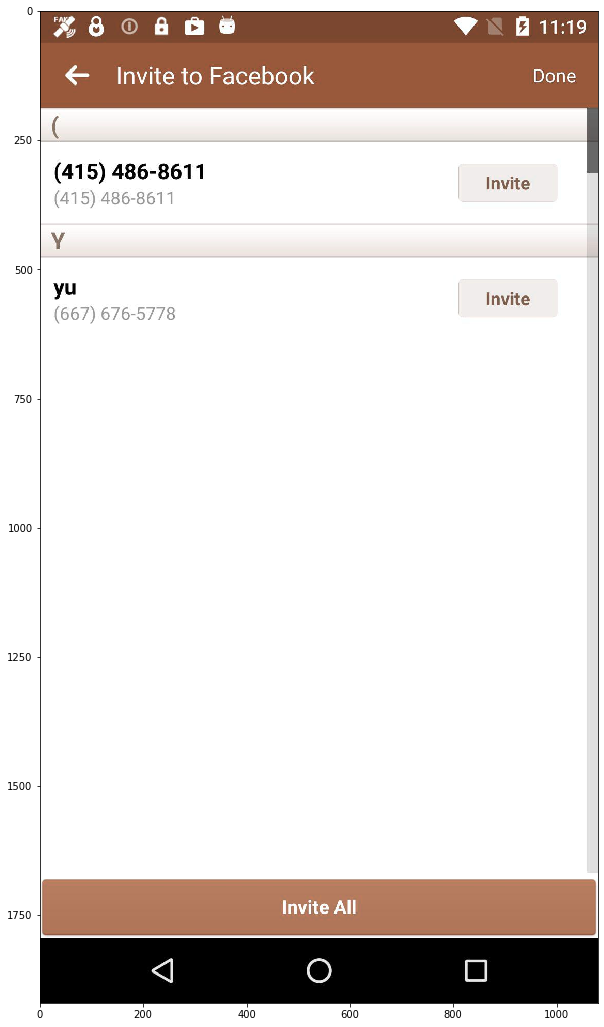

In [7]:
root = dataset_path.joinpath(data[0],data[1])
image_path = root.joinpath(f"{data[2]}.jpg").as_posix()
json_path = root.joinpath(f"{data[2]}.json").as_posix()

image = cv2.imread(image_path)

image_height,image_width,_ = image.shape

with open(json_path, "r") as f:
    orig_annotation = json.load(f)
    _,_,width,height = orig_annotation["bounds"]
    width_ratio = image_width / width
    height_ratio = image_height / height
    annotation = parse_annotation(orig_annotation, width_ratio, height_ratio)
   
original_image = image.copy()


plt.imshow(original_image)

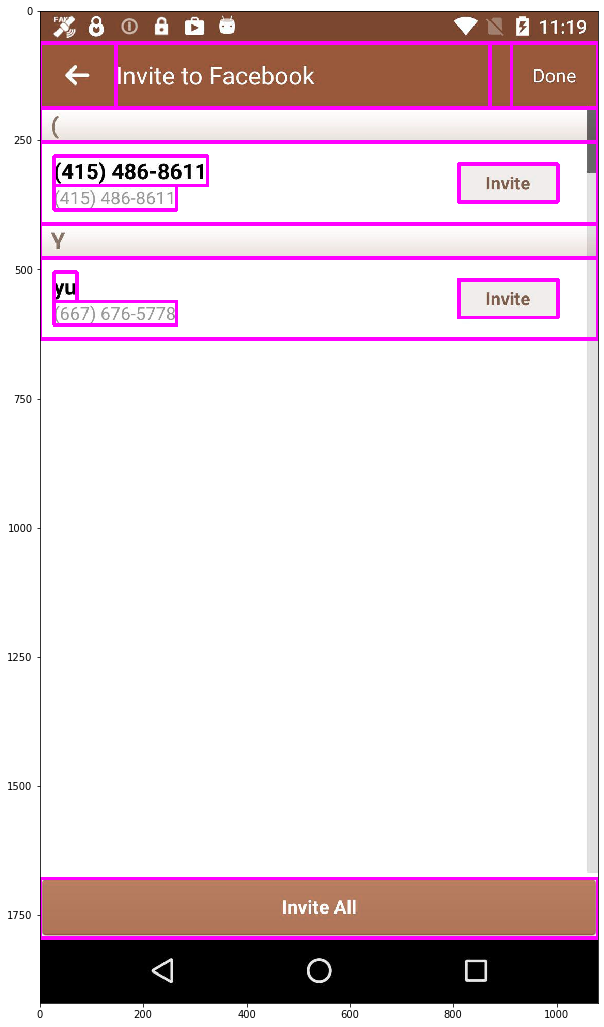

In [9]:
image = original_image.copy()
for k,v in annotation.items():
    for item in v:
        bounds = item["bounds"]
        cv2.rectangle(image, bounds["start"], bounds["end"], color=(255,0,255), thickness=5)

plt.imshow(image)

{'class_name': 'com.facebook.ui.titlebar.Fb4aTitleBar', 'bounds': {'start': (0, 63), 'end': (1080, 189)}, 'resource_id': 'com.facebook.katana:id/titlebar', 'text': ''}


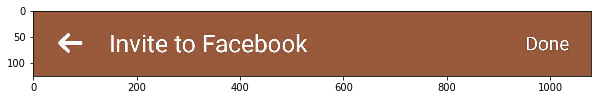

In [30]:
item = annotation["Toolbar"][0]
bounds = item["bounds"]

x1,y1 = bounds["start"]
x2,y2 = bounds["end"]

print(item)

cropped = original_image[y1:y2,x1:x2,:]
plt.imshow(cropped)

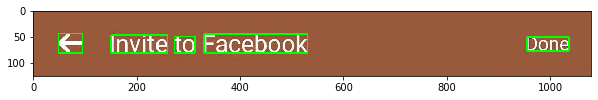

In [31]:
img = cropped.copy()
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    if d['conf'][i] == '-1':
        continue

    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    

plt.imshow(img)